# Adversarial-attacks

### Контакты

canvas profile id: `24795191`

canvas name: `dmitryg`

drive link: https://drive.google.com/open?id=1kFAfbwnc0i5UKQQ5QeaU_LM6DnkH83if


### Итог

Реализован метод атаки One-step target class method (OTCM)

```
 Успешно атаковано 4354 (87.08%) изображений из 5000
 на 0/5    1 из 1000 классов (0.1%)
 на 1/5   13 из 1000 классов (1.3%)
 на 2/5   46 из 1000 классов (4.6%)
 на 3/5  120 из 1000 классов (12.0%)
 на 4/5  211 из 1000 классов (21.1%)
 на 5/5  609 из 1000 классов (60.9%)
 ```

## Задание

**White-box задача**: дана сеть ResNet18/**ResNet50**, предобученная на миллионе фоток лиц. Каждому лицу она ставит в соответствие вектор размерности 512, для лиц одного и того же человека векторы близки, для лиц разных людей -- далеки. Ваша задача -- **"атаковать" несколько тысяч картинок (лиц).** То есть, изменить их таким образом, чтобы сеть стала находить в этих лицах другие лица. 

 * Близость векторов измеряется в MSE. 
 * Архитектура и веса сети известны.
 * Саму сеть при этом менять никак нельзя! 
 * расстояние по метрике SSIM между изначальной картинкой X и атакованной картинкой не должно быть ниже 0.95. 
 
Папка с архитектурой сети, весами, и данными: https://drive.google.com/drive/folders/1UUQib6dbqErFf4dRqDAoptiMhnL05xdS?usp=sharing

SSIM реализована в skimage:
`from skimage.measure import compare_ssim`

Сеть училась на картинках, обработанных следующим образом:
```
preprocessing = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.Scale(112),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD),
                ])

MEAN = [0.485, 0.456, 0.406], STD = [0.229, 0.224, 0.225]
```


### Импорт

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
from torchvision import transforms
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # ! считалось на cuda не проверено на cpu


In [0]:
from skimage.measure import compare_ssim 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

### Копирование и распаковка данных

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%%bash
echo "Copying data and model"
drive_path="/content/drive/My Drive/MFTI/Final/Adversarial_Attacks"
for file in $(ls "$drive_path"); do
    if [ ! -e $file ]; then
    cp --verbose "$drive_path/$file" .
    fi
done

echo $'\nExtracting imgs.zip'
if [ ! -d "imgs" ]; then
    unzip -q imgs.zip "imgs/*" 
fi

echo "Done. Total: $(ls imgs/ | wc -l) files"

Copying data and model
'/content/drive/My Drive/MFTI/Final/Adversarial_Attacks/Adversarial_dmitryg.ipynb' -> './Adversarial_dmitryg.ipynb'
'/content/drive/My Drive/MFTI/Final/Adversarial_Attacks/adv_images.zip' -> './adv_images.zip'
'/content/drive/My Drive/MFTI/Final/Adversarial_Attacks/best_model_chkpt-resnet50.t7' -> './best_model_chkpt-resnet50.t7'
'/content/drive/My Drive/MFTI/Final/Adversarial_Attacks/imgs.zip' -> './imgs.zip'
'/content/drive/My Drive/MFTI/Final/Adversarial_Attacks/pairs_list.csv' -> './pairs_list.csv'
'/content/drive/My Drive/MFTI/Final/Adversarial_Attacks/resnet18.py' -> './resnet18.py'
'/content/drive/My Drive/MFTI/Final/Adversarial_Attacks/resnet18_scale_fold0_best.pth.tar' -> './resnet18_scale_fold0_best.pth.tar'
'/content/drive/My Drive/MFTI/Final/Adversarial_Attacks/resnet50.py' -> './resnet50.py'
'/content/drive/My Drive/MFTI/Final/Adversarial_Attacks/y_target_cuda.pt' -> './y_target_cuda.pt'

Extracting imgs.zip
Done. Total: 10000 files


In [0]:
# %%bash 
# #remove all data in ~
# rm -rf /content/imgs
# drive_path="/content/drive/My Drive/MFTI/Final/Adversarial_Attacks"
# rm $(ls "$drive_path")

### Просмотр содержимого

In [6]:
df = pd.read_csv("pairs_list.csv")
df.describe()

source_imgs                                        target_imgs
count                                                1000                                               1000
unique                                               1000                                               1000
top     71d93c8bf5ef376e521f6af7e899676f6ca10f09.jpg|1...  c1dbc9ea3b1915fb2a35ad972e3ba2cec07cdefc.jpg|8...
freq                                                    1                                                  1

In [7]:
df.source_imgs[0].split('|')

['60f5fb295648e54bd1dc0c859c8fff620ee2eb40.jpg',
 'bc01280fd767ff125d851f2ccc887dce4afa834d.jpg',
 '254a446a0231b2f96699f254a880513fe9b20f39.jpg',
 '3a3a9ad1b942aa4f4c4420b214741cf73d43373e.jpg',
 '90f023cf9e5f998ef0605687a269799164ace637.jpg']

In [0]:
def expand_img_names(names_record, path_prefix='imgs/',  delimeter='|'):
    """split names by delimeter and add path_prefix for each"""
    return [path_prefix + name for name in names_record.split(delimeter)]

# expand_img_names(df.target_imgs[0])

In [0]:
def load_img(image_name):
    """load pil image to np.array"""
    with Image.open(image_name) as img:
        return np.array(img)

In [0]:
def show_srcntarget(row):
    """show source and target images for row in csv"""
    image_names = expand_img_names(df['source_imgs'][row]) + \
                expand_img_names(df['target_imgs'][row])

    images = list(map(load_img, image_names))

    fig = plt.figure(figsize=(12., 6.)) #size of thumb area
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(2, len(images) // 2),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)   

    plt.show()

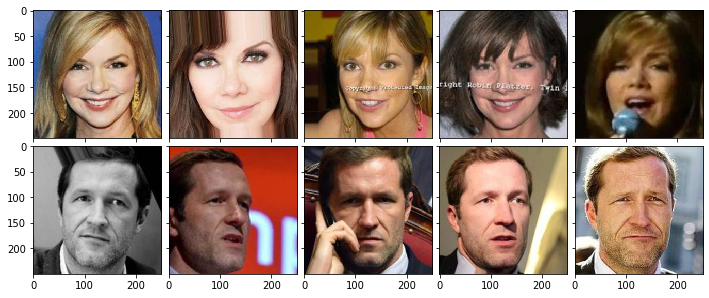

In [11]:
show_srcntarget(np.random.randint(0, len(df)))

### Загрузка модели

In [12]:
from resnet50 import ResNet50

model = ResNet50().to(device)
checkpoint = torch.load("./best_model_chkpt-resnet50.t7") 
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [0]:
_ = model.eval()

In [0]:
# Сеть училась на картинках, обработанных следующим образом:

MEAN = [0.485, 0.456, 0.406] 
STD = [0.229, 0.224, 0.225]

preprocessing = transforms.Compose([
transforms.CenterCrop(224),
transforms.Scale(112), #UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
transforms.ToTensor(),
transforms.Normalize(mean=MEAN, std=STD),
])


In [0]:
# inverse transform 
STD_INV = 1 / np.array(STD) # 1 / STD
MEAN_INV = -np.array(MEAN) * STD_INV # - MEAN * STD_INV

preprocessing_inv = transforms.Compose([
    transforms.Normalize(mean=MEAN_INV, std=STD_INV),
    transforms.ToPILImage()
])

In [0]:
# load first 10 images
image_names = expand_img_names(df['source_imgs'][0]) + \
                expand_img_names(df['target_imgs'][0])

images = list(map(load_img, image_names))

In [0]:
# test model
x = preprocessing(Image.fromarray(images[0])).to(device)

In [18]:
result = model.forward(x.unsqueeze(0))
print(result.shape)

torch.Size([1, 512])


In [0]:
#формально: расстояние по метрике SSIM между изначальной картинкой X и атакованной картинкой не должно быть ниже 0.95. 

In [20]:
# SSIM test
print("Same SSIM: ", compare_ssim(images[0], images[0], multichannel=True ))
print("Different: ", compare_ssim(images[0], images[5], multichannel=True ))

Same SSIM:  1.0
Different:  0.303510442480365


### Генерация $Y_{target}$

Расчёт и сохранение векторов $Y_{target}$ из $X_{target}$ представленных в **target_imgs**. 

Загружаем, т.к. лень считать повторно. Используем для оценки MSE в пределах класса.

In [0]:
class TargetsDataset(Dataset):
    """Loads Ytarget images"""
    def __init__(self, csv_file, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir       
        self.target_names = []

        df = pd.read_csv(csv_file)
        for record in df['target_imgs']:
            self.target_names += expand_img_names(record, self.root_dir)
     
    def __len__(self):
        return len(self.target_names)

    def __getitem__(self, idx):
        with Image.open(self.target_names[idx]) as image:
            if self.transform:
                return self.transform(image)
                
        return None

In [0]:
YT_BATCH_SIZE = 64

yt_dataset = TargetsDataset("pairs_list.csv","imgs/", preprocessing)
yt_loader = DataLoader(yt_dataset, batch_size=YT_BATCH_SIZE, shuffle=False,  num_workers=4,
                       pin_memory=True, drop_last=False)

In [0]:
# # test dataloader
# next(iter(loader)).to(device, non_blocking=True)

Расчет и сохранение нового `y_target`. 


In [0]:
# !nvidia-smi

In [0]:
if not os.path.exists("y_target_cuda.pt"):
    y_target = []
    for batch in tqdm_notebook(yt_loader, desc='Batch:'):    
        x = batch.to(device, non_blocking=True)
        y = model.forward(x)
        y_target.append(y.data)
        
        del x, batch, y
        torch.cuda.empty_cache()

    y_target = torch.cat(y_target)
    torch.save(y_target, 'y_target_cuda.pt')

    print("\nY_target: {}, type: {},  device: {}".format(y_target.shape, y_target.type(), y_target.device))
    print("Saved to: y_target_cuda.pt")    

In [0]:
#!cp y_target_cuda.pt /content/drive/My\ Drive/MFTI/Final/Adversarial_Attacks/

Загрузка файла с `y_target`

In [27]:
!ls -lh y_target_cuda.pt

-rw------- 1 root root 9.8M Feb 23 15:32 y_target_cuda.pt


In [28]:
y_target = torch.load('y_target_cuda.pt')
print("\nY_target: {}, type: {},  device: {}".format(y_target.shape, y_target.type(), y_target.device))


Y_target: torch.Size([5000, 512]), type: torch.cuda.FloatTensor,  device: cuda:0


### MSE в пределах класса

Расчёт MSELoss для каждой пары из каждой группы из 5 изображений одного класса 

In [0]:
loss_function = torch.nn.MSELoss()

losses = []
for i in range(0, len(y_target), 5):
    current = i
    while current < i+5:
        item = current + 1
        while item < i+5:
            comp_loss = loss_function(y_target[current], y_target[item]).cpu()
            losses.append(comp_loss)
            item += 1
        current += 1

In [30]:
print("Min:", np.min(losses))
print("Mean:", np.mean(losses))
print("Max:", np.max(losses))
print("Std:", np.std(losses))

Min: 9.495426e-05
Mean: 0.0013306465
Max: 0.0039951694
Std: 0.00047106648


(array([ 132., 1402., 3356., 2937., 1516.,  422.,  138.,   63.,   25.,
           9.]),
 array([9.4954259e-05, 4.8497578e-04, 8.7499729e-04, 1.2650188e-03,
        1.6550403e-03, 2.0450619e-03, 2.4350833e-03, 2.8251049e-03,
        3.2151265e-03, 3.6051478e-03, 3.9951694e-03], dtype=float32),
 <a list of 10 Patch objects>)

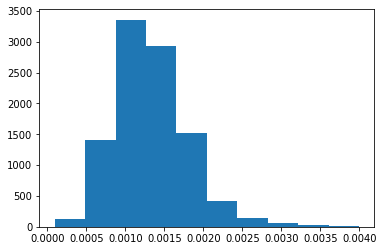

In [31]:
plt.hist(losses)

$2\sigma$

In [32]:
# 95%
np.mean(losses) + 2 * np.std(losses)

0.002272779413033277

Считаем что в пределах класса MSE <= 0.00227

## One-step target class method (OTCM)


Для атаки используется One-step target class method (A. Kurakin et al.) базирующийся на FGSM. Искажение исходного изображения происходит на малую величину $\epsilon$ в направлении противоположном знаку градиента. В отличиие от FGSM при расчете градиентов используется метка атакуемого класса, к которому необходимо приблизится.

$$x'=x-\rho$$

$$\rho = \epsilon\cdot sign(\nabla_X J(\theta,I_c, \ell_{target}))$$

где: $x'$ - искаженное изображение; $x, I_c$ - исходное изображение,  $\rho$ - вносимое искажение, $J(...)$ - функция потерь, $\theta$ - параметры модели, $\ell_{target}$ - метка целевого класса. Или:

$$X^{adv} = X_{src} - \epsilon\cdot sign(\nabla_X J(\theta, X_{src}, Y_{target}))$$



В данной реализации $\epsilon$ выбирается из списка с так, чтобы минимизировать MSE, и получить максимальное количество атакованных изображений с учётом условия на SSIM.
  
Описание метода: https://arxiv.org/abs/1712.07107 , https://arxiv.org/abs/1801.00553

In [0]:
class AdvDataset(Dataset):
    """loads source images and y_target"""
    def __init__(self, csv_file, root_dir, transform=None, 
                 y_targets_filename="y_target_cuda.pt"):
        self.transform = transform
        self.root_dir = root_dir       
        self.source_names = []
        self.y_target = torch.load(y_targets_filename).cpu()

        df = pd.read_csv(csv_file)
        for record in df['source_imgs']:
            self.source_names += expand_img_names(record, self.root_dir)
     
    def __len__(self):
        return len(self.source_names)

    def __getitem__(self, idx):
        with Image.open(self.source_names[idx]) as image:
            if self.transform:
                return self.transform(image), self.y_target[idx].clone().detach()
                
        return None

In [0]:
dataset = AdvDataset("pairs_list.csv","imgs/", preprocessing)
loader = DataLoader(dataset, batch_size=5, shuffle=False,  num_workers=4,
                       pin_memory=True, drop_last=False)

In [0]:
loss = torch.nn.MSELoss()

In [0]:
def get_ssim(x, x_adv):
    """
    return ssim values for each pair in batch
    x, x_adv - torch.tensors
    """
    x = x.clone().detach().cpu()
    x_adv = x_adv.clone().detach().cpu()
    ssim = []
    for i in range(x.shape[0]):
        img = np.array(preprocessing_inv(x[i]))
        img_adv = np.array(preprocessing_inv(x_adv[i]))
        ssim.append(compare_ssim(img, img_adv, multichannel=True))
    return np.array(ssim)

In [0]:
%%bash
adv_dir="adv_imgs"

if [ ! -d "$adv_dir" ]; then
    mkdir "$adv_dir"
else
    rm -rf "$adv_dir"
    mkdir "$adv_dir"
fi

In [0]:
def save_adv(idx, eps, x_adv, x_grad, path="./adv_imgs"):
    """save adv.images, perturbation images, and x_grad to files"""
    x = x_adv.clone().detach().cpu()
    r = eps * x_grad.clone().detach().cpu()

    for i in range(x_adv.shape[0]):
        file_name = os.path.join(path, "{:04d}".format(idx * 5 + i))
        preprocessing_inv(x[i]).save(file_name + ".jpg")
        preprocessing_inv(r[i]).save(file_name + "_rho.jpg")

    torch.save(x_grad, os.path.join(path, "xgrad_{:04d}_cuda.pt".format(idx)))




In [0]:
# !nvidia-smi

In [0]:
epsilons = [0.002, 0.01, 0.02, 0.03, 0.04, 0.05, 0.055, 0.06, 0.07, 0.10, 0.15, 0.5 ]

In [41]:
MAX_LOSS = 0.00227 
MIN_SSIM = 0.95

stats = []
for idx, batch in enumerate(tqdm_notebook(loader, desc='Batch:')):
    # X_grad calculation block
    X, yt = batch
    X, yt = X.to(device, non_blocking=True), yt.to(device, non_blocking=True)

    X.requires_grad_(True)
    yt.requires_grad_(False)    
    
    output = model(X)
    
    if X.grad != None:
        X.grad.zero_()
    model.zero_grad()

    loss_cal = loss(output, yt)
    loss_cal.backward()

    X_grad = torch.sign(X.grad.data)
    
    del batch, output
    torch.cuda.empty_cache()

    # epsilon calculation block
    with torch.no_grad():
        _adv_stats = {}

        minL = 100500
        max_s_count = 0
        best_S, best_e, best_Xadv = None, None, None
        
        for eps in epsilons:
            X_adversarial = X.data - eps * X_grad
            
            output_adversarial = model.forward(X_adversarial)

            L = loss(yt, output_adversarial)
            S = get_ssim(X, X_adversarial)
            s_count = np.count_nonzero(S > MIN_SSIM)

            if L <= minL and L <= MAX_LOSS and s_count >= max_s_count:
                minL = L
                max_s_count = s_count
                best_S = S
                best_e = eps
                best_Xadv = X_adversarial.clone().detach()
                
            elif minL <= MAX_LOSS:
                break

        _adv_stats = {"index": idx, "epsilon": best_e, "loss": float(minL.cpu()), 
                      "ssim_min": best_S.min(), "ssim_max": best_S.max(),
                      "ssim_mean": best_S.mean(), "ssim": best_S,
                      "success_count":  max_s_count,
                      "success": np.array(best_S > MIN_SSIM, dtype=np.uint8) 
                      }

        stats.append(_adv_stats)

        if best_Xadv != None:
            save_adv(idx, best_e, best_Xadv, X_grad)
        else:
            save_adv(idx, eps, Xadv, X_grad)          

# print(len(stats))

In [0]:
# !zip -r adv_images.zip adv_*

In [0]:
# !cp adv_images.zip /content/drive/My\ Drive/MFTI/Final/Adversarial_Attacks/

### Результаты

In [0]:
stats_df = pd.DataFrame(stats)
stats_df.to_csv("adv_stats.csv", index=False)

In [45]:
print("Успешно атаковано {} ({:.2%}) изображений".format(stats_df["success_count"].sum(), stats_df["success_count"].sum() / 5000) )

for i, item in enumerate(stats_df.groupby("success_count")["success_count"].count()):
    print(" на {}/5 {: 4d} из 1000 классов ({:.1%})".format(
         i,  item, item / 1000) )

Успешно атаковано 4354 (87.08%) изображений
 на 0/5    1 из 1000 классов (0.1%)
 на 1/5   13 из 1000 классов (1.3%)
 на 2/5   46 из 1000 классов (4.6%)
 на 3/5  120 из 1000 классов (12.0%)
 на 4/5  211 из 1000 классов (21.1%)
 на 5/5  609 из 1000 классов (60.9%)


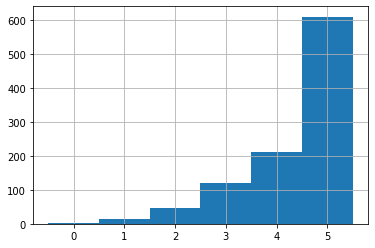

In [46]:
stats_df["success_count"].hist(bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5])

In [0]:
def load_imgs(image_names):
    return list(map(load_img, image_names))
    
def show_attack_results(idx, adv_path="adv_imgs"):
    print("Attack results for idx# ", str(idx))
    src_names = expand_img_names(df['source_imgs'][idx])
    target_names = expand_img_names(df['target_imgs'][idx])
    adv_names = [os.path.join(adv_path, "{:04d}.jpg".format(idx * 5 + i)) for i in range(5)]
    rho_names = [name.replace(".jpg", "_rho.jpg") for name in adv_names]
    src_imgs = load_imgs(src_names)
    target_imgs = load_imgs(target_names)
    adv_imgs = load_imgs(adv_names)
    rho_imgs = load_imgs(rho_names)

    epsilon, ssim, loss = stats_df.loc[idx,['epsilon', 'ssim', 'loss']]


    figure, ax = plt.subplots(5,4, figsize=(12,17))
    for i in range(5):
        
        
        text_color = 'red' if ssim[i] < MIN_SSIM else 'black'
        
        ax[i][0].set_title('Source '+ str(idx * 5 + i))
        ax[i][0].imshow(src_imgs[i])
        ax[i][0].axis('off')

        ax[i][1].set_title('Perturbation ')
        ax[i][1].imshow(rho_imgs[i])
        ax[i][1].text(0.5, -0.13,"eps={:.2f}".format(epsilon),ha="center", 
                    transform=ax[i][1].transAxes)
        ax[i][1].axis('off')

        ax[i][2].set_title('Adversarial', color=text_color)
        ax[i][2].imshow(adv_imgs[i])
        ax[i][2].text(0.5, -0.13,"SSIM={:.4f}".format(ssim[i]),ha="center", 
                    transform=ax[i][2].transAxes, color=text_color)
        ax[i][2].axis('off')

        ax[i][3].set_title('Target ' + str(idx * 5 + i))
        ax[i][3].imshow(target_imgs[i])
        ax[i][3].text(0.5, -0.13,"Loss={:.6f}".format(loss),ha="center", 
                    transform=ax[i][3].transAxes)
        ax[i][3].axis('off')


    plt.show()


#### Примеры неудачных атак

Худший результат 0/5 (индекс 611)
Attack results for idx#  611


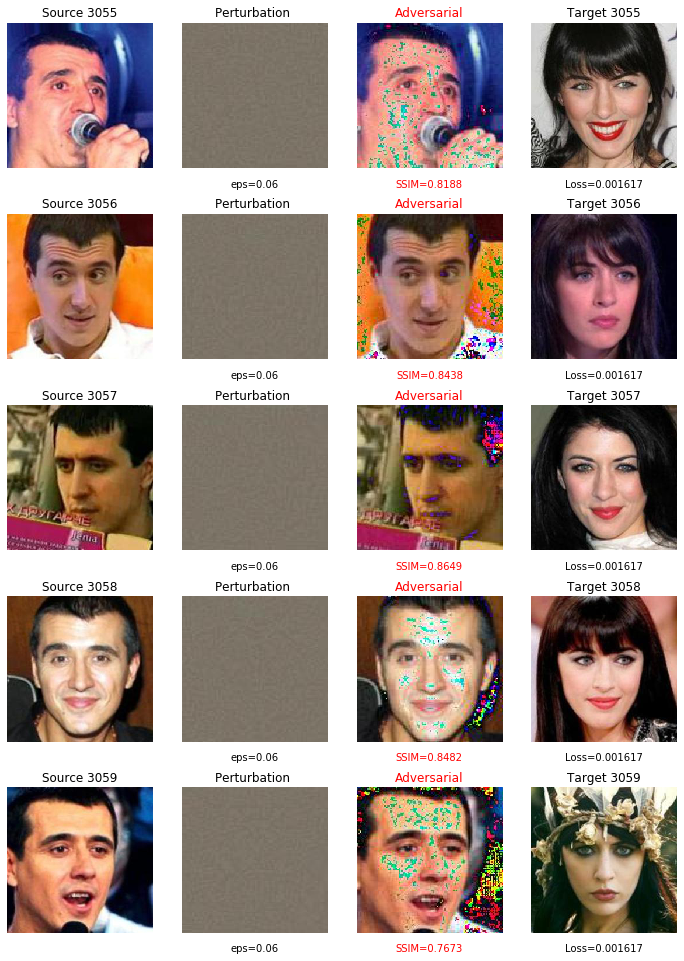

In [48]:
print("Худший результат 0/5 (индекс {})".format(stats_df[stats_df["success_count"] == 0].index[0]))
show_attack_results(611)

Индексы худших пар:  [ 39  85 138 371 494 551 576 611 834 880 938 944 948 990]
index 39 success [0 0 0 1 0]


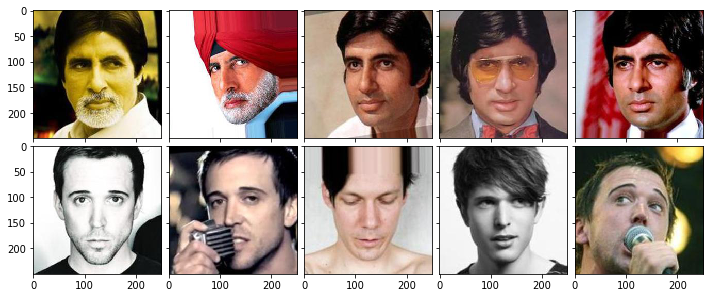

index 85 success [0 0 0 1 0]


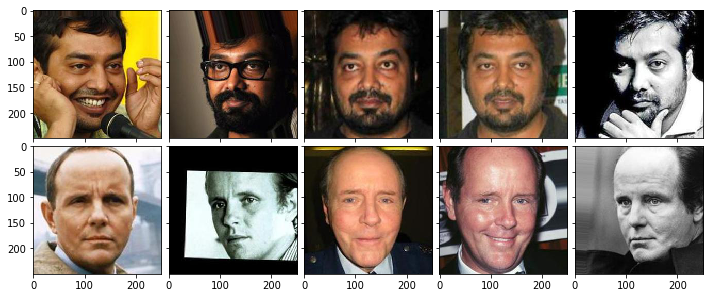

index 138 success [0 0 0 0 1]


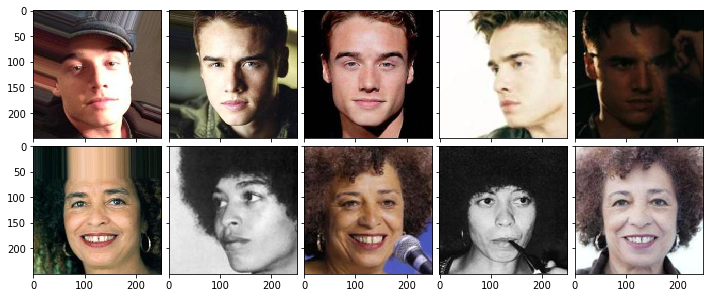

index 371 success [0 1 0 0 0]


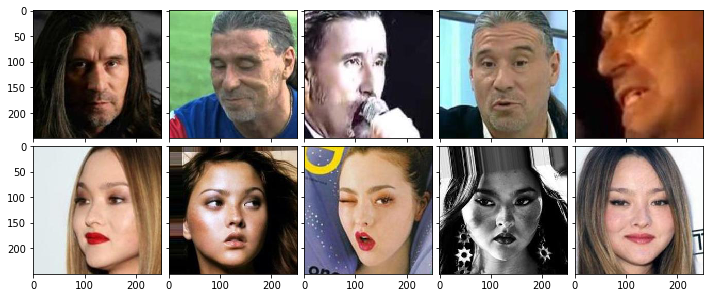

index 494 success [0 0 0 0 1]


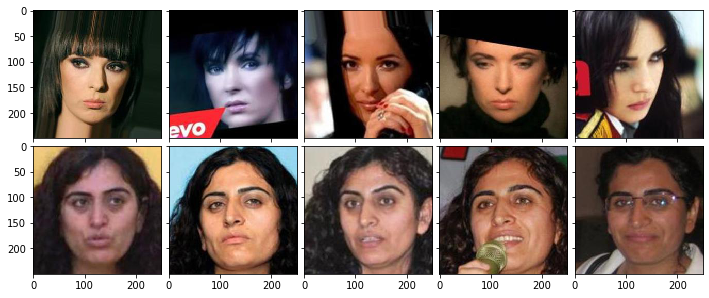

In [49]:
print("Индексы худших пар: ", stats_df[stats_df["success_count"] < 2].index.values)
for index in stats_df[stats_df["success_count"] < 2].index.values[:5]:
    print("index {} success {}".format(index, stats_df.at[index, "success"] ))
    show_srcntarget(index)

Attack results for idx#  371


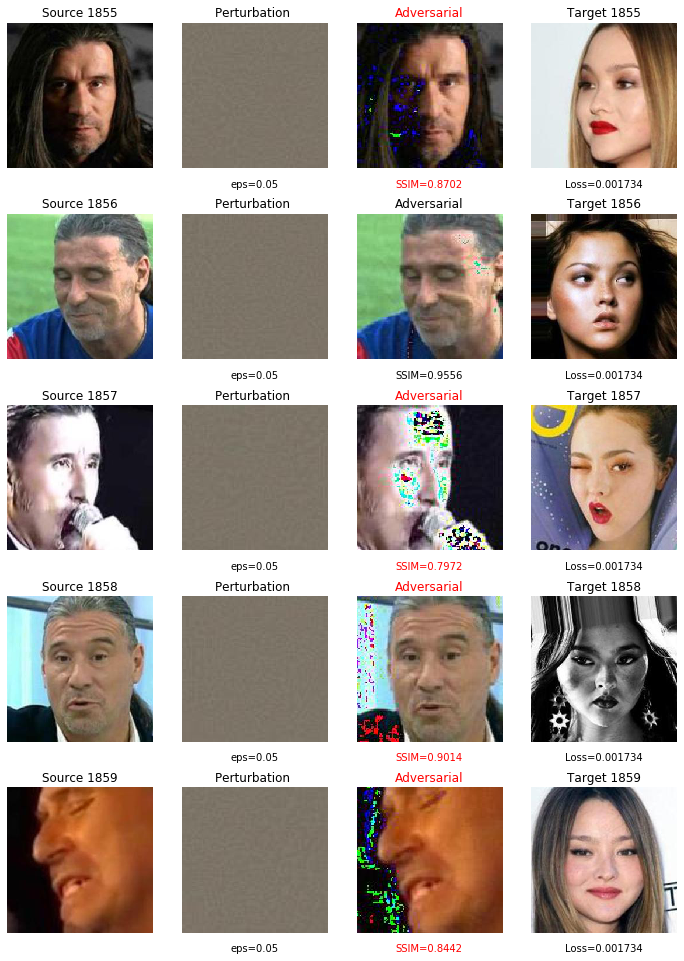

In [50]:
show_attack_results(371)

#### Примеры успешно атакованых пар

Примеры удачно атакованных пар: [1 2]
index 1 success [1 1 1 1 1]


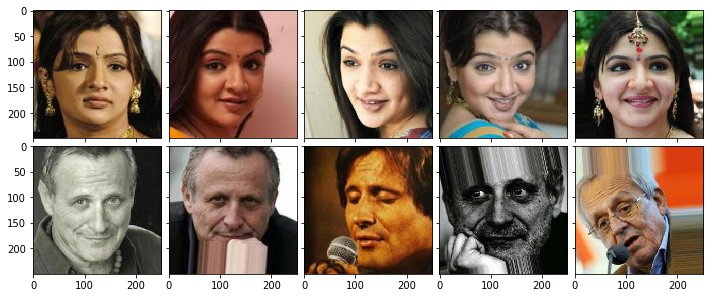

index 2 success [1 1 1 1 1]


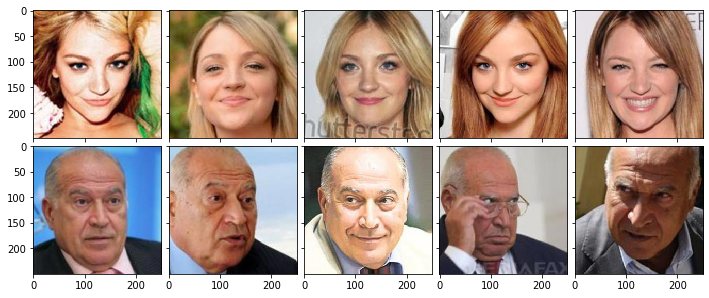

In [51]:
print("Примеры удачно атакованных пар: {}".format(stats_df[stats_df["success_count"] == 5].index.values[:2]))
for index in stats_df[stats_df["success_count"] == 5].index.values[:2]:
    print("index {} success {}".format(index, stats_df.at[index, "success"] ))
    show_srcntarget(index)

Attack results for idx#  2


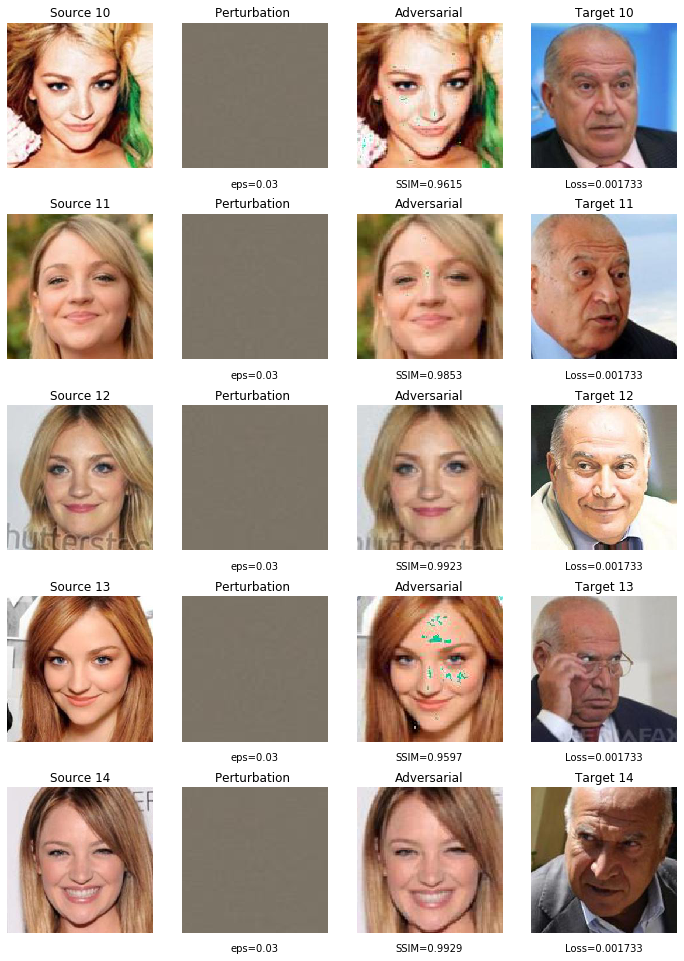

In [52]:
show_attack_results(2)

Attack results for idx#  0


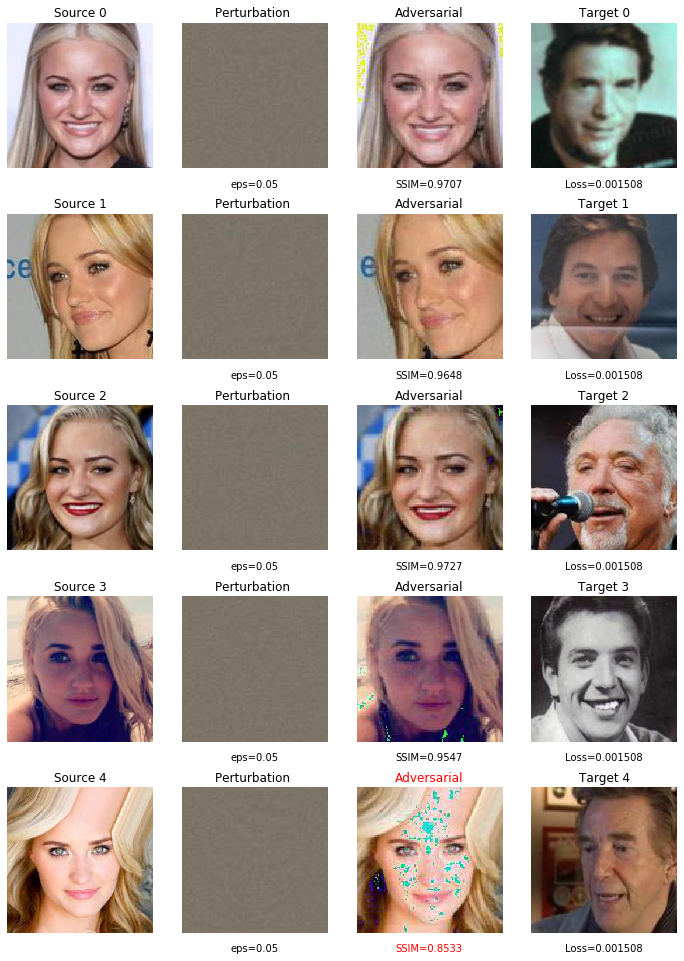

In [53]:
show_attack_results(0)